In [1]:
import pandas as pd
from ast import literal_eval
import numpy as np
import math
import matplotlib.pyplot as plt


class VideoTrajectory:
    def __init__(self, path):
        self.path = path
        trajectory = pd.read_csv(path, names=['A', 'B'])
        # convert string to tuples
        for ball in ['A', 'B']:
            trajectory[ball] =  trajectory[ball].apply(literal_eval)
        # compute distance between balls per frame
        trajectory['distance']= [np.linalg.norm(np.asarray(trajectory.loc[t, 'A']) - np.asarray(trajectory.loc[t, 'B'])) for t in range(250)]
        self.trajectory = trajectory

    def plotBallDists(self):
        plt.plot(self.trajectory.distance)
        plt.xlabel("Frames")
        plt.ylabel("Distance between A and B")

    def getCollisionParams(self):
        if '9a' or '10a' in self.path:
            t_collision = self.trajectory['distance'].iloc[30:].idxmin()
        else:
            t_collision = self.trajectory['distance'].idxmin()  #becuase python starts w 0
        self.t_collision = t_collision
        dframes = 2
        p1 = self.trajectory.iloc[t_collision - dframes]['A']
        p2 = self.trajectory.iloc[t_collision]['A']
        self.p1 = {'frame_'+str((t_collision-dframes)): p1 }
        self.p2 = {'frame_'+str(t_collision): p2 }
        self.p0 = {'frame_'+str(t_collision - dframes - 5): self.trajectory.iloc[t_collision - dframes - 5]['A']}
        angle = math.degrees(math.atan(abs(p1[1] - p2[1])/abs(p1[0] - p2[0])))
        self.collisionAngle_A = angle
        self.compute_vel()
        print('stimulus: '+self.path.split('.csv')[0])
        print(f'Collision frame number: {t_collision} \nCollision xy location: {self.trajectory.loc[t_collision, "A"]} \nCollision angle: {angle}')
        print(f'Ball A\'s instantaneous velocity at collision: {self.velocity[t_collision]}')

    def compute_vel(self):
        self.trajectory['A_fwd'] = 0 # frame-wise displacement
        self.trajectory.loc[range(1,len(self.trajectory)), 'A_fwd'] = [np.linalg.norm(np.array(self.trajectory.A[t-1])
                                                                                      - np.array(self.trajectory.A[t]))
                                                                       for t in range(1, len(self.trajectory))]
        self.velocity = np.gradient(self.trajectory.A_fwd.cumsum())

    def plotTrajectores(self, title):
        plt.scatter(*zip(*self.trajectory.B))
        plt.scatter(*zip(*self.trajectory.A))
        plt.title(title)

    def plotAvelocity(self):
        self.compute_vel()
        plt.plot(np.gradient(self.trajectory.A_fwd.cumsum()))


def trajectory_difference(stim1, stim2, ball):
    t_diffs = []
    for t in range(len(stim1.trajectory)):
        t_diffs.append(np.linalg.norm(np.asarray(stim1.trajectory.loc[t, ball]) - np.asarray(stim2.trajectory.loc[t, ball])))
    if ball == 'A':
        t_diffs = t_diffs[stim2.t_collision:]

    plt.plot(t_diffs)
    print(f'Total difference between trajectories: {sum(t_diffs)}')

def plot_stimTrajectory(stim1, stim2, filename):
    f, a = plt.subplots(figsize=(10, 5), ncols=2, sharey=True)

    a[0].scatter(*zip(*stim1.trajectory.B), )
    a[0].scatter(*zip(*stim1.trajectory.A))
    a[0].set_title("INANIMATE")
    a[0].set_aspect(2)
    a[1].scatter(*zip(*stim2.trajectory.B))
    a[1].scatter(*zip(*stim2.trajectory.A))
    a[1].set_title("ANIMATE")
    a[1].set_aspect(2)
    plt.savefig(filename)

## Physical stimulus collision parameters & trajectory

stimulus: trajectory_files/24_p_out_in
Collision frame number: 115 
Collision xy location: (37.69568634033203, 9.528247833251953, 0.9988230466842651) 
Collision angle: 8.128005756817092
Ball A's instantaneous velocity at collision: 0.5893122906814519

{'frame_108': (32.70823287963867, 8.81571102142334, 1.1790534257888794)}
{'frame_113': (36.287288665771484, 9.32710075378418, 1.0638574361801147)}


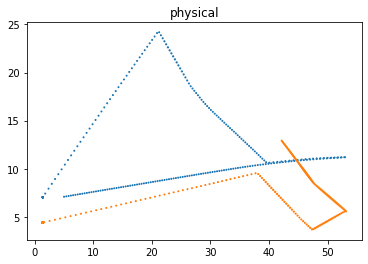

In [3]:
stim1 = VideoTrajectory('trajectory_files/24_p_out_in.csv')
stim1.getCollisionParams()
print('')
print(stim1.p0)
print(stim1.p1)
stim1.plotTrajectores('physical')

## Comparing Physical and Animated Collision Parameters

In [26]:
stim1.getCollisionParams()
print('')
stim2 = VideoTrajectory('trajectoryFiles/24_a_out_in.csv')
stim2.getCollisionParams()

stimulus: trajectoryFiles/24_p_out_in
Collision frame number: 115 
Collision xy location: (37.69568634033203, 9.528247833251953, 0.9988230466842651) 
Collision angle: 8.128005756817092
Ball A's instantaneous velocity at collision: 0.5893122906814519

stimulus: trajectoryFiles/24_a_out_in
Collision frame number: 115 
Collision xy location: (37.69568634033203, 9.528247833251953, 0.9988230466842651) 
Collision angle: 8.128005756817092
Ball A's instantaneous velocity at collision: 0.5893122906814483


## Ensure alls follows the same trajectory across physical and animate stimuli

Total difference between trajectories: 0.0


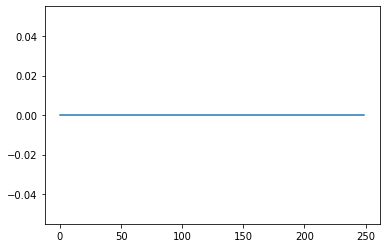

In [27]:
trajectory_difference(stim1, stim2, 'B')

Total difference between trajectories: 0.0


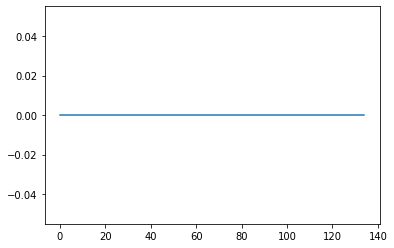

In [28]:
trajectory_difference(stim1, stim2, 'A')

## save the trajectory images

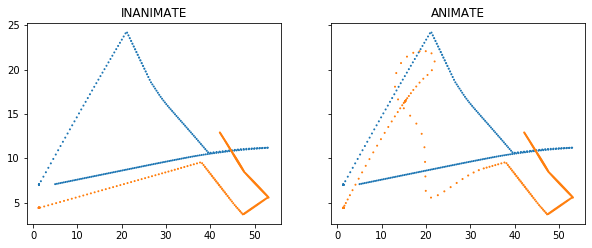

In [29]:
plot_stimTrajectory(stim1, stim2, 'trajectory_imgs/24_out_in_trajectories.png')

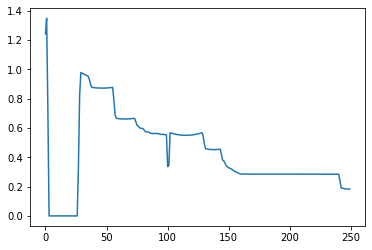

In [36]:
stim1.plotAvelocity()

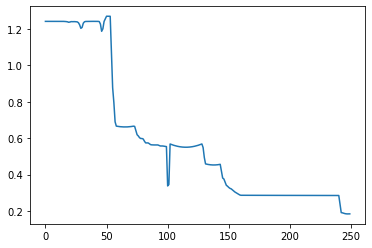

In [37]:
stim2.plotAvelocity()


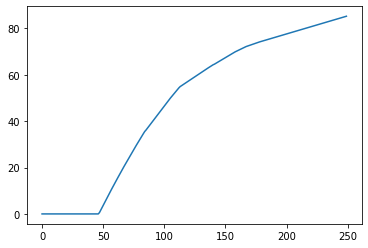

In [30]:
traj = stim1.trajectory
traj['A_fwd'] = 0
traj.loc[range(1,len(traj)), 'A_fwd'] = [np.linalg.norm(np.array(traj.A[t-1]) - np.array(traj.A[t])) for t in range(1, len(traj))]
plt.plot(traj.A_fwd.cumsum())

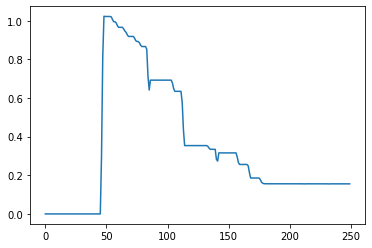

In [31]:
plt.plot(np.gradient(traj.A_fwd.cumsum()))

In [32]:
stim1.t_collision

113

Old code I used when trying to splice video segments pre/post collision that looked weird in the final videos

In [19]:
from moviepy.editor import *
import os
from natsort import natsorted

L =[]

for root, dirs, files in os.walk("blend/"):

    #files.sort()
    files = natsorted(files)
    for file in files:
        if os.path.splitext(file)[1] == '.mp4':
            filePath = os.path.join(root, file)
            video = VideoFileClip(filePath, fps_source='fps')
            L.append(video)

final_clip = concatenate_videoclips(L)
final_clip.to_videofile("output.mp4", fps=30, remove_temp=False)

t:  10%|█         | 26/252 [00:00<00:00, 256.13it/s, now=None]

Moviepy - Building video output.mp4.
Moviepy - Writing video output.mp4



Moviepy - Done !
Moviepy - video ready output.mp4
